# Imports

In [2]:
#Imports
import random
import os
import numpy as np
import torch
from matplotlib import pyplot as plt
import pickle
import cv2

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch import autograd
from torch.autograd import Variable
from torch.utils.data import Sampler
import torchvision.transforms.functional as TF
from torchvision import transforms, utils

# Dataset creation

In [3]:
class MASS_Roads_Dataset(Dataset):
    def __init__(self, data_dir, split):
        #store filenames
        self.filenames = os.listdir(os.path.join(data_dir, "sat"))
        self.filenames = sorted(self.filenames)
        #store file path
        self.filenames = [os.path.join(os.path.join(data_dir, "sat"), f) for f in self.filenames]
        
        #store labels (maps)
        self.labels = os.listdir(os.path.join(data_dir, "map"))
        self.labels = sorted(self.labels)
        #store label path
        self.labels = [os.path.join(os.path.join(data_dir, "map"), l) for l in self.labels]
        self.split = split
        
        #self.rand_img = [random.randint(0,1079: 94 %) for _ in range(131072)]
        
    #data augnemtation transforms
    def transform(self, image, mask):

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        #perform center crop of image
        mask = TF.center_crop(mask, 16)
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        #print(mask.shape)
        #mask = mask.view(1,256)
        mask = mask.view(256)
        
        return image, mask
    
    def __len__(self):
        #return size of dataset
        self.rand_img = [random.randint(0,1079) for _ in range(131072)]
        return len(self.filenames)
    
    def valid_patch_road(self, np_label_patch, not_valid_road_count):

        im = Image.fromarray(np_label_patch)

        white = 0

        for pixel in im.getdata():
            if pixel == (255): # check if road
                white += 1
        #print(white)     
        if(white==0):
            not_valid_road_count += 1
            return False, not_valid_road_count
        else:
            return True, not_valid_road_count

    def valid_patch_img(self, np_img_patch, np_label_patch, not_valid_road_count, not_valid_patch):
        
        #if we cant find a patch after searching 30 times take any patch
        if(not_valid_patch>30):
            return True, not_valid_road_count, not_valid_patch

        im = Image.fromarray(np_img_patch)

        white = 0
        size = ((np_img_patch.size)*3/4)/3 # if white pixels are greater than 3 quarters of image. Div by 3 because of 3 channels

        for pixel in im.getdata():
            if pixel == (255, 255, 255): # if all 3 channels only have 1 pixel
                white += 1
        #if 10 searchers yeild no result
        if(not_valid_road_count<10):
            valid_road, not_valid_road_count = self.valid_patch_road(np_label_patch, not_valid_road_count)
            #print(not_valid_road_count)
            if(not valid_road):
                return False, not_valid_road_count, not_valid_patch

        if(white>size):
            not_valid_patch += 1
            return False, not_valid_road_count, not_valid_patch
        else:
            return True, not_valid_road_count, not_valid_patch

    def patch_selection(self, img, label, pixel_bound):
        # takes in image and label pil images
        x, y = random.randint(0, pixel_bound), random.randint(0, pixel_bound)
        
        img_numpy = np.array(img)
        label_numpy = np.array(label)
        #extract patch
        img_patch = img_numpy[x:x+64,y:y+64,:]
        label_patch = label_numpy[x:x+64,y:y+64]
        #stop searching for road if too many miss
        not_valid_road_count = 0
        not_valid_patch = 0
        valid_patch, not_valid_road_count, not_valid_patch = self.valid_patch_img(img_patch, label_patch, not_valid_road_count, not_valid_patch)
        #check if paych is valid
        while(not valid_patch):
            x, y = random.randint(0, pixel_bound), random.randint(0, pixel_bound)
            
            img_patch = img_numpy[x:x+64,y:y+64,:]
            label_patch = label_numpy[x:x+64,y:y+64]
            
            valid_patch, not_valid_road_count, not_valid_patch = self.valid_patch_img(img_patch, label_patch, not_valid_road_count, not_valid_patch)
        #image_numpy = None
        return Image.fromarray(img_patch), Image.fromarray(label_patch)
    
    def __getitem__(self, idx):
        #open an image, apply transform to the image and the map, return image with map
        #random_idx = self.rand_img[idx]
        image = Image.open(self.filenames[idx])
        label = Image.open(self.labels[idx]) #maps
        
        if(self.split == "train"):
            image, label = self.patch_selection(image, label, 1434)
            image, label = self.transform(image, label)
        else:
            image = TF.to_tensor(image)
            label2 = TF.to_tensor(label) 
            image = image*(1-label2)
            label = TF.center_crop(label, 16)
            label = TF.to_tensor(label)
            label = label.view(256)
        return image, label, str(str(str(self.filenames[idx]).split('/')[-1]).split('.')[0])

# Dataloader declaration

In [4]:
def fetch_dataloader(types, data_dir, params):
    """
    Fetches the DataLoader object for each type in types from data_dir.
    Args:
        types: (list) has one or more of 'train', 'val', 'test' depending on which data is required
        data_dir: (string) directory containing the dataset
        params: (Params) hyperparameters
    Returns:
        data: (dict) contains the DataLoader object for each type in types
    """
    dataloaders = {}

    for split in ['train', 'valid_split', 'test_split']:
        if split in types:
            path = os.path.join(data_dir, split)

            # use the train_transformer if training data, else use eval_transformer without random flip
            if split == 'train':
                
                mass_roads_dataset = MASS_Roads_Dataset(path, split)
                
                dl = DataLoader(mass_roads_dataset, batch_size=params['batch_size'], shuffle=True,
                                        num_workers=params['num_workers'],
                                        pin_memory=params['cuda'])
            else:
                dl = DataLoader(MASS_Roads_Dataset(path, split), batch_size=params['batch_size'], shuffle=True,
                                num_workers=params['num_workers'],
                                pin_memory=params['cuda'])

            dataloaders[split] = dl
    return dataloaders

# Hyper parms

In [5]:
torch.cuda.is_available()

True

In [6]:
params = {
    "batch_size": 128,
    "num_workers": 6,
}

# use GPU if available
params["cuda"] = torch.cuda.is_available()

# Set the random seed for reproducible experiments
#torch.manual_seed(230)
#if params['cuda']: torch.cuda.manual_seed(230)
    
dataloaders = fetch_dataloader(['train'], "../data/mass_roads", params)
train_dl = dataloaders['train']


In [7]:
print(params)

{'batch_size': 128, 'num_workers': 6, 'cuda': True}


In [8]:
train_dl
print(len(train_dl.dataset))

1108


# Mnih Architecture

In [9]:
class mnih_nn(nn.Module):
    
    def __init__(self):
        super(mnih_nn, self).__init__()
        # 3 input image channel,  output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 64, 16, stride=4, bias = False)
        nn.init.xavier_uniform_(self.conv1.weight)
        #self.mp1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 112, 4, stride=1, bias = False)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(112, 80, 3, stride=1, bias = False)
        nn.init.xavier_uniform_(self.conv3.weight)
        #self.conv4 = nn.Conv2d(80, 1, kernel_size = 1)
        # an affine operation: y = Wx + b
        self.fc4 = nn.Linear(5120, 4096, bias = False)
        nn.init.xavier_uniform_(self.fc4.weight)
        self.fc5 = nn.Linear(4096, 256, bias = False)
        nn.init.xavier_uniform_(self.fc5.weight)

    def forward(self, x):
        in_size = x.size(0)
        #print(x.shape, 'Input')
        #h = F.relu(self.mp1(self.conv1(x)))
        h = F.relu(self.conv1(x))
        #print(h.shape, 'Conv1')
        h = F.relu(self.conv2(h))
        #print(h.shape, 'Conv2')
        h = F.relu(self.conv3(h))
        #print(h.shape, 'Conv3')
        #h = F.relu(self.conv4(h))
        #print(h.shape, 'Conv4')
        h = h.view(-1, 5120)
        #print(h.shape, 'Reshape Voodoo')
        # If the size is a square you can only specify a single number
        h = F.dropout(F.relu(self.fc4(h)), training=False)
        #print(h.shape, 'Linear1')
        h = self.fc5(h)
        #print(h.shape, 'Linear2')
        #print(x.data.shape[0])
        #self.pred = F.reshape(h, (x.data.shape[0], 16, 16))
        self.pred = h.reshape(h.size(0), -1)
        self.pred = torch.sigmoid(self.pred)
        return self.pred

In [10]:
def weighted_binary_cross_entropy(output, target, weights=None):
    output = torch.clamp(output, min=1e-7, max = 1-1e-7)
        
    if weights is not None:
        assert len(weights) == 2
        
        log_1 = torch.log(output)
        #log_1[log_1 != log_1] = 0
        log_0 = torch.log(1 - output)
        #log_0[log_0 != log_0] = 0
        loss = weights[1] * (target * log_1) + \
               weights[0] * ((1 - target) * log_0)
    else:
        log_1 = torch.log(output)
        #log_1[log_1 != log_1] = 0
        log_0 = torch.log(1 - output)
        #log_0[log_0 != log_0] = 0
        
        loss = target * log_1 + (1 - target) * log_0

    return torch.neg(torch.mean(loss))

In [ ]:
mnih_model = mnih_nn()
mnih_model.cuda()
optimizer = torch.optim.SGD(mnih_model.parameters(), lr = 0.001, momentum=0.9, weight_decay=0.001)

# Training loop

In [ ]:
mnih_model = torch.load('model_epoch_54.pt')

In [ ]:
for epoch in range(0,45):
    #print(epoch)
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        
        #get inputs
        inputs, masks = data
        #print("Iteration:", i," inputs: ", inputs.data.shape, "masks:", masks.data.shape)
        
        #wrap them in a variable
        inputs, masks = Variable(inputs).cuda(), (Variable(masks).cuda())
        
        #forward pass
        mask_pred = mnih_model(inputs)
        
        #compute and print loss
        loss = weighted_binary_cross_entropy(mask_pred, masks, weights = torch.Tensor([1, 1]).cuda()).cuda()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 1023 == 0 and i > 0:    # print every 200 mini-batches
            #print(epoch, i, loss.item())
            print('[%d, %5d] loss: %.6f' %(epoch, i, running_loss / 1024))
            running_loss = 0.0
            
    if((epoch+1)%5 == 0 and i>0):
        print("saving weights")
        torch.save(mnih_model, "model_epoch_"+str(epoch+55)+".pt")
        #pickle.dump(test_model, open("model_epoch_"+str(i)+".pkl", "wb"))

print('Finished Training')


In [ ]:
torch.save(mnih_model, '100_100000.pt')
#model = torch.load('filename.pt')

In [ ]:
# Started training on sunday 10:41
# ended at approx 0.234.... loss

# Testing Segment

In [ ]:
mnih_model = torch.load('model_epoch_54.pt')

# Accuracy

In [11]:
#fix test data loading
mnih_model = torch.load('model_epoch_99.pt')
dataloaders = fetch_dataloader(['test_split'], "../data/mass_roads", params)
testloader = dataloaders['test_split']
print(len(testloader.dataset))

396900


Iteration: 0  inputs:  torch.Size([128, 3, 64, 64]) masks: torch.Size([128, 256])
20278885_15_6404


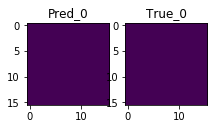

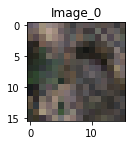

Iteration: 0  inputs:  torch.Size([128, 3, 64, 64]) masks: torch.Size([128, 256])
10378780_15_4362


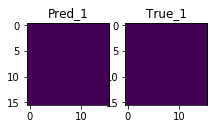

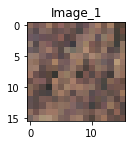

Iteration: 0  inputs:  torch.Size([128, 3, 64, 64]) masks: torch.Size([128, 256])
20728960_15_3472


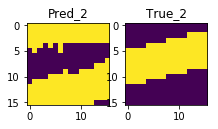

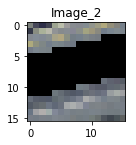

Iteration: 0  inputs:  torch.Size([128, 3, 64, 64]) masks: torch.Size([128, 256])
20278885_15_1765


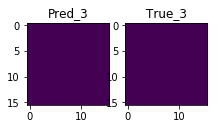

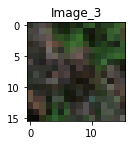

Iteration: 0  inputs:  torch.Size([128, 3, 64, 64]) masks: torch.Size([128, 256])
18478930_15_244


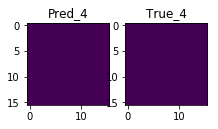

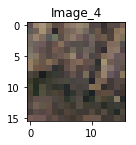

Iteration: 0  inputs:  torch.Size([128, 3, 64, 64]) masks: torch.Size([128, 256])
20728960_15_6215


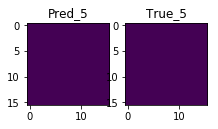

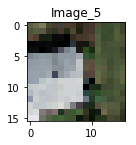

Iteration: 0  inputs:  torch.Size([128, 3, 64, 64]) masks: torch.Size([128, 256])
22229050_15_3658


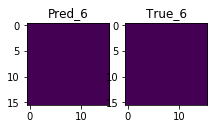

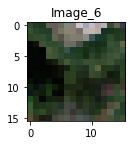

Iteration: 0  inputs:  torch.Size([128, 3, 64, 64]) masks: torch.Size([128, 256])
23878540_15_1438


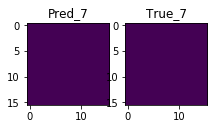

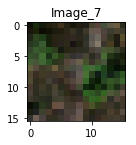

Iteration: 0  inputs:  torch.Size([128, 3, 64, 64]) masks: torch.Size([128, 256])
23428540_15_6072


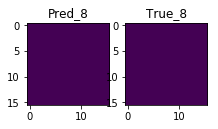

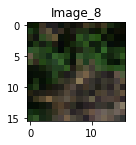

Iteration: 0  inputs:  torch.Size([128, 3, 64, 64]) masks: torch.Size([128, 256])
16078870_15_3982


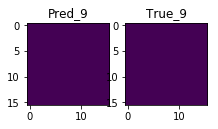

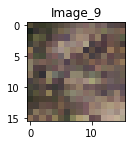

In [78]:
for k in range(10):
    for i, data in enumerate(testloader, 0):
        #print(i)
        if i>0:
                break

        #get inputs
        inputs, masks, names = data
        print("Iteration:", i," inputs: ", inputs.data.shape, "masks:", masks.data.shape)
        inputs, masks = Variable(inputs).cuda(), Variable(masks).long().cuda()
        #print(inputs.shape)
        #print("Iteration:", i," inputs: ", inputs.data.shape, "masks:", masks.data.shape)
        mask_pred = mnih_model(inputs)
        #mask_pred[mask_pred>=0.5] = 1
        #mask_pred[mask_pred<0.5] = 0
        #print("Iteration:", i, " mask_pred:", mask_pred.data.shape)
        thresh = Variable(torch.Tensor([0.79])).cuda()
        mask_pred = (mask_pred >= thresh).float()*1
        mask_pred = mask_pred.view(128,16,16)
        masks = masks.view(128,16,16)
        
        inputs0 = inputs[:,0]
        inputs1 = inputs[:,1]
        inputs2 = inputs[:,2]
        inputs2 = torch.stack([inputs0, inputs1, inputs2], dim=3)
        #print("Iteration:", i," inputs2: ", inputs2.data.shape, "masks:", masks.data.shape)
        #print("Iteration:", i, " mask_pred:", mask_pred.data.shape, "masks:", masks.data.shape)
        center_image = inputs2[15].cpu().detach().numpy()
        center_image = center_image[24:(24+16),24:(24+16)]
        
        print(names[15])

        plt.figure(k, figsize=(5,5))
        plt.subplot(1,3,1)
        plt.title('Pred_'+str(k))
        plt.imshow(mask_pred[15].cpu().detach().numpy())
        plt.subplot(1,3,2)
        plt.title('True_'+str(k))
        plt.imshow(masks[15].cpu().detach().numpy())
        plt.show()
        plt.subplot(1,3,3)
        plt.title('Image_'+str(k))
        plt.imshow(center_image)
        plt.show()

In [ ]:
total_road = np.asscalar(total_road.cpu().numpy())

In [ ]:
print('The total ratio of road pixels is: %d %%' % (
    100 * total_road / total))

In [13]:
#thresh = np.linspace(0.0, 1.0, num=19)
#best results on 0.65
thresh = np.array([0.5])
for k in range(0, len(thresh)):
    correct = 0
    total = 0
    total_road = 0
    conf_matrix = np.zeros([2,2])
    with torch.no_grad():
        mnih_model = torch.load('model_epoch_89.pt')
        mnih_model = mnih_model.cuda()
        for i, data in enumerate(testloader, 0):
            inputs, labels, names = data
            inputs, labels = Variable(inputs).cuda(), Variable(labels).float().cuda()
            outputs = mnih_model(inputs)
            t = torch.Tensor([thresh[k]]).cuda()  # threshold
            outputs = (outputs > t).float() * 1
            #print("inputs: ", inputs.data.shape, " masks:", labels.data.shape, " outputs:", outputs.data.shape)
            labels = labels.view(-1,256)
            #print("inputs: ", inputs.data.shape, " masks:", labels.data.shape, " outputs:", outputs.data.shape)
            total_road += torch.sum(labels)
            conf_matrix += confusion_matrix(labels.cpu().numpy().reshape(-1), outputs.cpu().numpy().reshape(-1))
            diff = (labels - outputs).cpu().numpy()
            correct += np.count_nonzero(diff==0)
            total += diff.size
            #save images
            outputs = outputs.view(-1,16,16)
            outputs = outputs.cpu().numpy()
            for num_images in range(0,outputs.shape[0]):
                #im = Image.fromarray(outputs[num_images], mode='L') # RGB
                #im.save("../data/mass_roads/"+"test_split_pred/"+str(names[num_images])+".tiff", "TIFF")
                cv2.imwrite("../data/mass_roads/"+"test_split_pred/"+str(names[num_images])+".png", outputs[num_images])

    print('Accuracy of the network on the 396900  test images: %d %%' % (
        100 * correct / total))
    print("Threshold: " + str(thresh[k]))
    print(conf_matrix)
    print("\n")

Accuracy of the network on the 396900  test images: 89 %
Threshold: 0.5
[[86187122. 10654329.]
 [  320814.  4444135.]]




In [14]:
print(total_road)

tensor(4764949., device='cuda:0')


In [ ]:
3550430/(93291021+3550430)

In [ ]:
10599984./(86241467.+10599984.)

In [ ]:
1372869./(1372869. + 3392080.)

In [ ]:
100-29

In [15]:
3797513. +  967436.

4764949.0

In [25]:
test = torch.tensor([[0,1,1,0],[0,1,0,1]])

In [26]:
torch.nonzero(test).size(0)

4

In [30]:
len(test)

2

In [16]:
thresh = np.linspace(0.78, 0.79, num=5)
for k in range(0, len(thresh)):
    correct = 0
    total = 0
    total_road = 0
    conf_matrix = np.zeros([2,2])
    with torch.no_grad():
        mnih_model = torch.load('model_epoch_89.pt')
        mnih_model = mnih_model.cuda()
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs).cuda(), Variable(labels).float().cuda()
            outputs = mnih_model(inputs)
            t = torch.Tensor([thresh[k]]).cuda()  # threshold
            outputs = (outputs > t).float() * 1
            #print("inputs: ", inputs.data.shape, " masks:", labels.data.shape, " outputs:", outputs.data.shape)
            labels = labels.view(-1,256)
            #print("inputs: ", inputs.data.shape, " masks:", labels.data.shape, " outputs:", outputs.data.shape)
            total_road += torch.sum(labels)
            conf_matrix += confusion_matrix(labels.cpu().numpy().reshape(-1), outputs.cpu().numpy().reshape(-1))
            diff = (labels - outputs).cpu().numpy()
            correct += np.count_nonzero(diff==0)
            total += diff.size

    print('Accuracy of the network on the 396900  test images: %d %%' % (
        100 * correct / total))
    print("Threshold: " + str(thresh[k]))
    print(conf_matrix)
    print("\n")

Accuracy of the network on the 396900  test images: 95 %
Threshold: 0.78
[[93722397.  3119054.]
 [ 1638902.  3126047.]]


Accuracy of the network on the 396900  test images: 95 %
Threshold: 0.7825
[[93769548.  3071903.]
 [ 1663988.  3100961.]]


Accuracy of the network on the 396900  test images: 95 %
Threshold: 0.785
[[93816983.  3024468.]
 [ 1689102.  3075847.]]


Accuracy of the network on the 396900  test images: 95 %
Threshold: 0.7875000000000001
[[93863569.  2977882.]
 [ 1714430.  3050519.]]


Accuracy of the network on the 396900  test images: 95 %
Threshold: 0.79
[[93910016.  2931435.]
 [ 1740413.  3024536.]]




In [17]:
print(total_road, total)

tensor(4764949., device='cuda:0') 101606400


In [29]:
correct = 0
total = 0
total_road = 0
road_ratio = 4.65*4764949.0/101606400.0
conf_matrix = np.zeros([2,2])
with torch.no_grad():
    mnih_model = torch.load('model_epoch_89.pt')
    mnih_model = mnih_model.cuda()
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs).cuda(), Variable(labels).float().cuda()
        outputs = mnih_model(inputs)
        outputs = (outputs*torch.Tensor([road_ratio]).cuda())/(outputs*torch.Tensor([road_ratio]).cuda() + (((torch.Tensor([1]).cuda()-outputs)*torch.Tensor([1-road_ratio]).cuda())))
        t = torch.Tensor([0.5]).cuda()  # threshold
        outputs = (outputs > t).float() * 1
        #print("inputs: ", inputs.data.shape, " masks:", labels.data.shape, " outputs:", outputs.data.shape)
        labels = labels.view(-1,256)
        #print("inputs: ", inputs.data.shape, " masks:", labels.data.shape, " outputs:", outputs.data.shape)
        total_road += torch.sum(labels)
        conf_matrix += confusion_matrix(labels.cpu().numpy().reshape(-1), outputs.cpu().numpy().reshape(-1))
        diff = (labels - outputs).cpu().numpy()
        correct += np.count_nonzero(diff==0)
        total += diff.size

print('Accuracy of the network on the 396900  test images: %d %%' % (
    100 * correct / total))
print(conf_matrix)

Accuracy of the network on the 396900  test images: 95 %
[[93758942.  3082509.]
 [ 1658293.  3106656.]]
